# Portfolio Analysis

In [51]:
import pandas as pd
import numpy as np
import datetime as dt
import os
#from collections import Counter
#import glob
import math
#from scipy import stats
#import pandas_datareader as web
import matplotlib.pyplot as plt
import statsmodels.api as sm_old
import statsmodels.formula.api as sm
#import scipy.optimize as sco
#import scipy.interpolate as sci
#from functools import reduce
#import seaborn as sns

### Function definiton

In [2]:
def simple_ret(signal, ret, mkt, cost):
    longs = signal.eq(1).sum(axis=1)
    shorts = signal.eq(-1).sum(axis=1)
    costs = (shorts+longs) * tc
    vw=signal*mkt
    returns=vw*mtl_ret.loc[vw.index[0]:]
    ret=returns.sum(axis=1)
    return ret

In [3]:
def vm_score(signal, cap): # O(n^3)
    tot = signal.copy()
    for i in range(cap.shape[0]):
        for j in range(cap.shape[1]):
            for z in range(j+1,cap.shape[1]):
                tot.values[i][j]=cap.values[i][j]
                if signal.values[i][j] >= signal.values[i][z]:
                    tot.values[i][j] += cap.values[i][z]
    for i in range(len(tot)):
        tot.values[i] = (tot.values[i] / cap.sum(axis = 1)[i])*100
    return tot

In [4]:
def signal_formation(score, buy, sell):
    signal=score.copy()
    for i in range(len(score)):
        #b=score.values[i].max()*buy
        #buy=round(buy*score.max(axis=1)[i])
        #sell=round(sell*score.max(axis=1)[i])
        top=score.iloc[i].nlargest(buy).dropna()
        bot=score.iloc[i].nsmallest(sell).dropna()
        # give 1 if score > buy AND if mom_score > mom
        # give -1 if score > buy AND if mom_score > mom 
        signal.values[i] = np.where(np.logical_and(score.values[i] > top[-1], score.values[i-1] != 1), 1, 0)
        signal.values[i] = np.where(score.values[i] < bot[-1], -1, signal.values[i])
    return signal

In [5]:
def valuem(score, mom_score, buy, sell, mom):
    signal=score.copy()
    for i in range(len(score)):
        # give 1 if NOT already in portfolio AND score > buy AND if mom_score > mom
        signal.values[i] = np.where(np.logical_and(score.values[i] > buy, mom_score.values[i] > mom, score.values[i-1] != 1), 1, 0)
        # give -1 if score > sell AND if mom_score > mom 
        signal.values[i] = np.where(np.logical_and(score.values[i] > sell, mom_score.values[i] > mom), -1, signal.values[i])
    return signal

In [6]:
def build_strat(signal, ret, mkt, cost):
    ret=ret.loc[signal.index[0]:]
    # Calculating transaction costs (total positions * TC)
    longs = signal.eq(1).sum(axis=1)
    shorts = signal.eq(-1).sum(axis=1)
    costs = (shorts+longs) * cost
    # Value weighting the signal
    vw_sig = signal * mkt 
    returns =  vw_sig * ret
    # Calculate cumulative returns o each asset
    cum_ret = (1 + returns).cumprod() - 1 
    # Cumulative returns of the signal
    total_cum_ret = cum_ret.sum(axis = 1) - costs
    return total_cum_ret

In [7]:
def summary_stats(df):
    for i in df.columns:
        print(i)
        total_return = round(((1 + df[i]).cumprod()-1)[-1]*100,2)
        average_return = round((df[i].mean()*12)*100,2)
        standard_deviation = round((df[i].std())*math.sqrt(12)*100,2)
        kurtosis = round(df[i].kurt() - 3,2)
        skew = round(df[i].skew(),2)
        best_month = round(df[i].max()*100,2)
        worst_month = round(df[i].min()*100,2)
        positive_month = round(df[i][df[i] > 0].shape[0] / len(df[i])*100,2)
        mdd = round((((1 + df[i]).cumprod() - (1 + df[i]).cumprod().cummax()).min()*100),2)
        print(f"Total Return = {total_return}%")
        print(f"Average Yearly Return = {average_return}%")
        print(f"Standard Deviation = {standard_deviation}%")
        print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
        print(f"Exess Kurtosis = {kurtosis}")
        print(f"Skewness = {skew}")
        print(f"Best Month = {best_month}%")
        print(f"Worst Month = {worst_month}%")
        print(f"Positive Month = {positive_month}%")
        print(f"Maximum Drawdown = {mdd}%")
        print(" ")

### Data gathering

In [8]:
# Convert data to csv if necessary
# Get the list of all files and directories
path = r"C:\Users\hardo\Desktop\value-mom\data" # Adjust path accordingly
dir_list = os.listdir(path)

# Remove extensions
dir_list=[x.split('.')[0] for x in dir_list]

print("Files and directories in '", path, "' :")
 
# prints all files
print(dir_list)

Files and directories in ' C:\Users\hardo\Desktop\value-mom\data ' :
['benchmark', 'book_val', 'entp_val', 'price']


In [9]:
# Creating dataframes from the data
for i in dir_list:
    globals()[i] = pd.read_csv("data/"+i+".csv")
    globals()[i]["Dates"] = pd.to_datetime(globals()[i]["Dates"])
    globals()[i].set_index("Dates", inplace=True)
    # Only use data from 2000 up to 2021
    globals()[i] = globals()[i].loc[ globals()[i].index.year >= 2001 ]
    globals()[i] = globals()[i].loc[ globals()[i].index.year <= 2021 ]
    # Keep only ticker as column names
    globals()[i].rename(columns = lambda x : str(x)[:-10], inplace = True)

### Data Curation

In [10]:
# Constructing book value measure
yr_book = book_val.resample('Y').last()

book = yr_book.shift(1).resample('M').bfill().drop(index=yr_book.index[0])

In [11]:
# Constructing Price measures
yr_price = price.resample('Y').last()

pfye = yr_price.shift(1).resample('M').bfill().drop(index=yr_price.index[0])

In [12]:
mtl_book = book_val.resample('M').first()
mtl_book = mtl_book[mtl_book.index >= book.index[0]]

In [13]:
mtl_price = price.resample('M').first()
mtl_price = mtl_price[mtl_price.index >= book.index[0]]

In [14]:
# Constructing value weights
lag=2
mtl_mkt = entp_val.resample('M').last()
lagged_mtl_mkt = mtl_mkt.shift(periods=lag)
lagged_mtl_mkt.drop(mtl_mkt.index[:lag], inplace=True)
mkt = (mtl_mkt.div(lagged_mtl_mkt.sum(axis=1), axis=0))
mkt = mkt[mkt.index >= book.index[0]]

In [15]:
# Book price annual lagged 
bpal = np.log(book/pfye)
# Book price monthly current
bpmc = (mtl_book/mtl_price)

C:\Users\hardo\anaconda3\envs\quant\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\hardo\anaconda3\envs\quant\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [16]:
# Benchmark construction
bench=benchmark.pct_change().resample('M').agg(lambda x: (x+1).prod() - 1)
bench_ret=(1 + bench).cumprod() - 1

In [17]:
# Constructing price returns
mtl_ret = price.pct_change().resample('M').agg(lambda x: (x+1).prod() - 1)
mtl_ret_12 = mtl_ret.rolling(12).agg(lambda x: (x+1).prod() - 1)
mtl_ret_12.dropna(inplace = True)
mtl_ret_12 = mtl_ret_12.loc[mkt.index[0]:]

### Signal Formation

In [18]:
# Score formation
cap=lagged_mtl_mkt.loc[bpmc.index[0]:] # Market cap

In [19]:
#bpal_score = vm_score(bpal, cap)

In [20]:
bpmc_score = vm_score(bpmc, cap)

In [21]:
mom_score = vm_score(mtl_ret_12, cap)

In [22]:
# Variables
tc = 0.001    # transaction costs per position change
buy = 90     # buy treshhold buy=score.max()*0.9
sell = 70   # sell treshhold
m = 0.02      # mom treshhold

In [23]:
# single factor portfolios signal formation

#norm_bpal_sig = signal_formation(bpal_score, buy, sell)
norm_bpmc_sig = signal_formation(bpmc_score, buy, sell)
norm_mom_sig = signal_formation(mom_score, buy, sell)

In [24]:
# single factor portfolios returns

#ret_norm_bpal= build_strat(norm_bpal_sig, mtl_ret, mkt, tc)
ret_norm_bpmc= build_strat(norm_bpmc_sig, mtl_ret, mkt, tc)
ret_norm_mom = build_strat(norm_mom_sig, mtl_ret, mkt, tc)

#simple_bpal = 0.7*ret_norm_bpal + 0.3*ret_norm_mom
simple_bpmc = 0.7*ret_norm_bpmc + 0.3*ret_norm_mom

In [25]:
# avg_v/m signal formation

#score_avg_bpal = (bpal_score + mom_score)/2
score_avg_bpmc = (bpmc_score + mom_score)/2
#avg_bpal_sig = signal_formation(score_avg_bpal, buy, sell)
avg_bpmc_sig = signal_formation(score_avg_bpmc, buy, sell)

# avg_v/m portfolio returns

#avg_bpal= build_strat(avg_bpal_sig, mtl_ret, mkt, tc)
avg_bpmc = build_strat(avg_bpmc_sig, mtl_ret, mkt, tc)

In [26]:
# value|m signal formation
buy=0.8
sell=0.06
m=0.5
#valuem_bpal_sig = valuem(bpal_score, mom_score, buy, sell, m)
valuem_bpmc_sig = valuem(bpmc_score, mom_score, buy, sell, m)

In [27]:
# value|m portfolio returns

#valuem_bpal= build_strat(valuem_bpal_sig, mtl_ret, mkt, tc)
valuem_bpmc = build_strat(valuem_bpmc_sig, mtl_ret, mkt, tc)

In [28]:
#Simple returns
sbpmc=simple_ret(valuem_bpmc_sig, mtl_ret, mkt, tc)

In [29]:
s7030sig=0.7*norm_bpmc_sig + 0.3*norm_mom_sig
savg=simple_ret(avg_bpmc_sig, mtl_ret, mkt, tc)
s7030=simple_ret(s7030sig, mtl_ret, mkt, tc)

### Performance Analysis

Full Sample Strategy Comparison


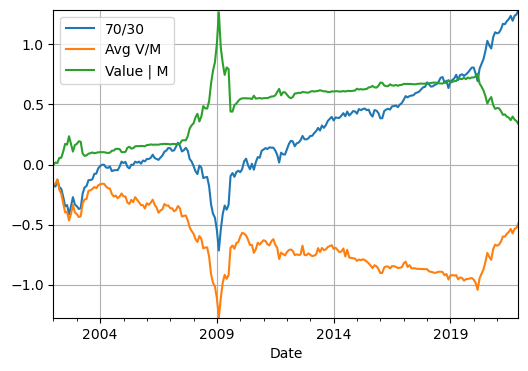

In [30]:
print("Full Sample Strategy Comparison")
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(1, 1, 1)
simple_bpmc.plot(label = '70/30')
avg_bpmc.plot(label = "Avg V/M")
valuem_bpmc.plot(label = 'Value | M')
ax2.grid()
ax2.set_xlabel('Date')
ax2.legend()
plt.margins(0,0)
plt.show()

First Half Sample Strategy Comparison


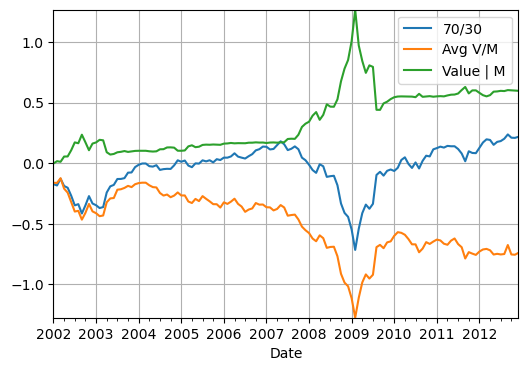

In [31]:
print("First Half Sample Strategy Comparison")
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(1, 1, 1)
simple_bpmc[:"2012"].plot(label = '70/30')
avg_bpmc[:"2012"].plot(label = "Avg V/M")
valuem_bpmc[:"2012"].plot(label = 'Value | M')
ax2.grid()
ax2.set_xlabel('Date')
ax2.legend()
plt.margins(0,0)
plt.show()

Second Half Sample Strategy Comparison


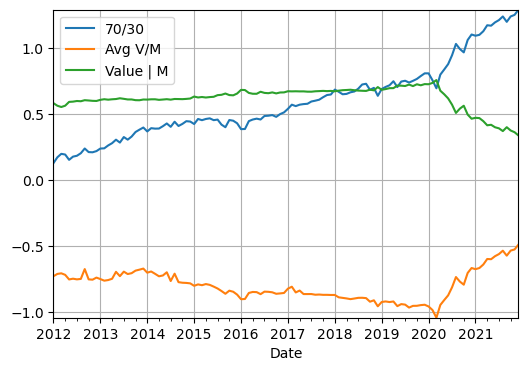

In [32]:
print("Second Half Sample Strategy Comparison")
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(1, 1, 1)
simple_bpmc["2012":].plot(label = '70/30')
avg_bpmc["2012":].plot(label = "Avg V/M")
valuem_bpmc["2012":].plot(label = 'Value | M')
ax2.grid()
ax2.set_xlabel('Date')
ax2.legend()
plt.margins(0,0)
plt.show()

In [33]:
benchmark=bench_ret.squeeze()

Full Sample Market Comparison


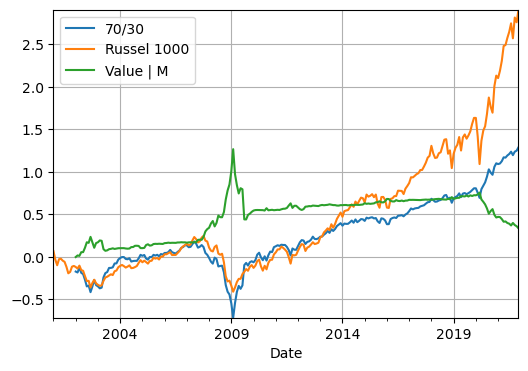

In [34]:
print("Full Sample Market Comparison")
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(1, 1, 1)
simple_bpmc.plot(label = '70/30')
benchmark.plot(label = "Russel 1000")
valuem_bpmc.plot(label = 'Value | M')
ax2.grid()
ax2.set_xlabel('Date')
ax2.legend()
plt.margins(0,0)
plt.show()

First Half Sample Market Comparison


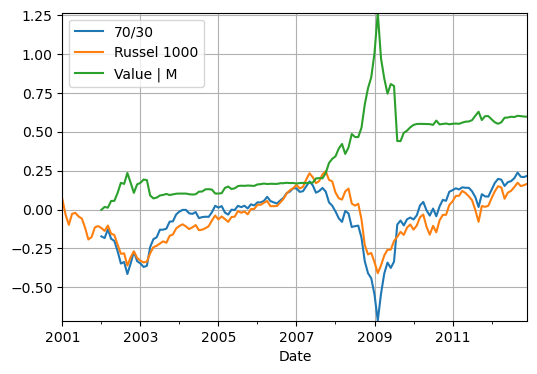

In [35]:
print("First Half Sample Market Comparison")
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(1, 1, 1)
simple_bpmc[:"2012"].plot(label = '70/30')
benchmark[:"2012"].plot(label = "Russel 1000")
valuem_bpmc[:"2012"].plot(label = 'Value | M')
ax2.grid()
ax2.set_xlabel('Date')
ax2.legend()
plt.margins(0,0)
plt.show()

Second Half Sample Market Comparison


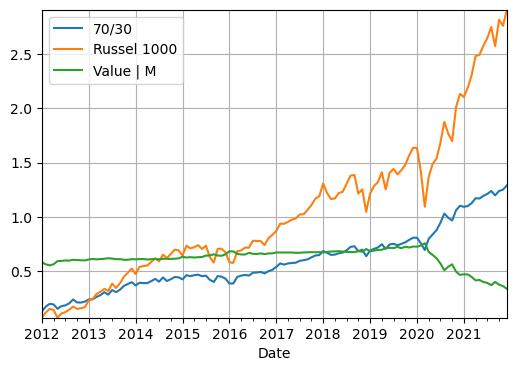

In [36]:
print("Second Half Sample Market Comparison")
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(1, 1, 1)
simple_bpmc["2012":].plot(label = '70/30')
benchmark["2012":].plot(label = "Russel 1000")
valuem_bpmc["2012":].plot(label = 'Value | M')
ax2.grid()
ax2.set_xlabel('Date')
ax2.legend()
plt.margins(0,0)
plt.show()

### Statistical Analysis

In [37]:
s7030.name = "70/30"
savg.name = "AvgV/M"
sbpmc.name = "V/M"

In [38]:
merged = sbpmc.reset_index().join(savg.reset_index(),rsuffix='_y')

In [39]:
merged = merged.join(s7030.reset_index(),rsuffix='_y')

In [40]:
merged.drop(columns=["Dates_y"], inplace=True)

In [41]:
section1 =merged.set_index("Dates")

In [42]:
section1

,V/M,AvgV/M,70/30
Dates,,,
2002-01-31,0.021186,-0.018395,-0.018829
2002-02-28,0.018722,-0.018927,-0.017015
2002-03-31,-0.014932,-0.011274,0.041738
2002-04-30,0.049723,-0.050780,-0.050317
2002-05-31,0.005710,-0.008427,-0.006852
...,...,...,...
2021-08-31,-0.020277,0.025048,0.025059
2021-09-30,0.030546,-0.036315,-0.036846
2021-10-31,-0.025916,0.037349,0.037755


In [43]:
print("Full sample stats")
summary_stats(section1)

Full sample stats
V/M
Total Return = 17.66%
Average Yearly Return = 1.69%
Standard Deviation = 12.88%
Sharpe Ratio = 0.13
Exess Kurtosis = 18.2
Skewness = -1.81
Best Month = 19.43%
Worst Month = -28.07%
Positive Month = 58.75%
Maximum Drawdown = -168.59%
 
AvgV/M
Total Return = -43.74%
Average Yearly Return = -1.86%
Standard Deviation = 14.41%
Sharpe Ratio = -0.13
Exess Kurtosis = 13.51
Skewness = 1.51
Best Month = 28.78%
Worst Month = -20.75%
Positive Month = 42.08%
Maximum Drawdown = -72.49%
 
70/30
Total Return = 210.72%
Average Yearly Return = 6.88%
Standard Deviation = 15.68%
Sharpe Ratio = 0.44
Exess Kurtosis = 7.74
Skewness = 0.85
Best Month = 28.85%
Worst Month = -20.8%
Positive Month = 63.75%
Maximum Drawdown = -87.39%
 


In [44]:
first_half = section1[:"2012"]
print("First half sample: 2002-2012:")
summary_stats(first_half)

First half sample: 2002-2012:
V/M
Total Return = 53.57%
Average Yearly Return = 5.33%
Standard Deviation = 16.38%
Sharpe Ratio = 0.33
Exess Kurtosis = 11.43
Skewness = -1.72
Best Month = 19.43%
Worst Month = -28.07%
Positive Month = 65.15%
Maximum Drawdown = -148.64%
 
AvgV/M
Total Return = -54.96%
Average Yearly Return = -5.68%
Standard Deviation = 17.93%
Sharpe Ratio = -0.32
Exess Kurtosis = 9.17
Skewness = 1.48
Best Month = 28.78%
Worst Month = -20.75%
Positive Month = 37.12%
Maximum Drawdown = -72.49%
 
70/30
Total Return = 19.16%
Average Yearly Return = 3.41%
Standard Deviation = 19.36%
Sharpe Ratio = 0.18
Exess Kurtosis = 4.96
Skewness = 0.94
Best Month = 28.85%
Worst Month = -20.8%
Positive Month = 56.82%
Maximum Drawdown = -87.39%
 


In [45]:
second_half = section1["2012":]
print("Second half sample: 2002-2012:")
summary_stats(second_half)

Second half sample: 2002-2012:
V/M
Total Return = -24.12%
Average Yearly Return = -2.57%
Standard Deviation = 6.05%
Sharpe Ratio = -0.42
Exess Kurtosis = 2.34
Skewness = -1.47
Best Month = 4.54%
Worst Month = -7.97%
Positive Month = 50.83%
Maximum Drawdown = -42.5%
 
AvgV/M
Total Return = 25.66%
Average Yearly Return = 2.59%
Standard Deviation = 7.96%
Sharpe Ratio = 0.33
Exess Kurtosis = 1.38
Skewness = 1.24
Best Month = 9.82%
Worst Month = -6.07%
Positive Month = 49.17%
Maximum Drawdown = -31.95%
 
70/30
Total Return = 197.14%
Average Yearly Return = 11.36%
Standard Deviation = 9.26%
Sharpe Ratio = 1.23
Exess Kurtosis = -1.55
Skewness = 0.1
Best Month = 9.81%
Worst Month = -6.07%
Positive Month = 71.67%
Maximum Drawdown = -21.53%
 


### Regression

In [46]:
returns=sbpmc.reset_index()
returns.rename(columns={'Dates':'Date'}, inplace=True)
returns['Date'] = returns['Date'].astype(str)
returns["Date"] = returns.apply(lambda row: str(row.Date[0:4]) + "-" + str(row.Date[5:7]), axis=1)
returns.set_index('Date', inplace=True)

In [47]:
ff3_df = pd.read_csv("ff3/FF3 Data.csv")
ff3_df['Date'] = ff3_df['Date'].astype(str)
ff3_df["Date"] = ff3_df.apply(lambda row: str(row.Date[0:4]) + "-" + str(row.Date[4:6]), axis=1)
ff3_df.set_index('Date', inplace=True)
for i in ff3_df.columns:
    ff3_df[i] = ff3_df[i].div(100)

In [48]:
regression_df = pd.merge(returns, ff3_df, left_index=True, right_index=True)

In [49]:
regression_df

,V/M,Mkt-RF,SMB,HML,RF
Date,,,,,
2002-01,0.021186,-0.0144,0.0119,0.0344,0.0014
2002-02,0.018722,-0.0229,-0.0100,0.0216,0.0013
2002-03,-0.014932,0.0424,0.0421,0.0106,0.0013
2002-04,0.049723,-0.0520,0.0596,0.0388,0.0015
2002-05,0.005710,-0.0138,-0.0321,0.0153,0.0014
...,...,...,...,...,...
2021-08,-0.020277,0.0291,-0.0043,-0.0016,0.0000
2021-09,0.030546,-0.0437,0.0072,0.0508,0.0000
2021-10,-0.025916,0.0665,-0.0235,-0.0048,0.0000


In [52]:
# CAPM Model FULL SAMPLE
print("Full sample CAPM Model Regression")
Y_capm = regression_df["V/M"]
X_capm = regression_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
print("\n")

# FF3 Model FULL SAMPLE
print("Full Sample FF3 Model Regression")

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = regression_df["V/M"]
X_ff3 = regression_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print(" ")

Full sample CAPM Model Regression
                            OLS Regression Results                            
Dep. Variable:                    V/M   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     182.6
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           2.90e-31
Time:                        18:42:19   Log-Likelihood:                 518.38
No. Observations:                 240   AIC:                            -1033.
Df Residuals:                     238   BIC:                            -1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0

In [53]:
# CAPM Model First Half Sample
print("First Half Sample CAPM Model Regression")

reg_df = regression_df[:"2012"]
Y_capm = reg_df["V/M"]
X_capm = reg_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
print("\n")

# FF3 Model First Half Sample
print("First Half Sample FF3 Model Regression")

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = reg_df["V/M"]
X_ff3 = reg_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print("\n")

First Half Sample CAPM Model Regression
                            OLS Regression Results                            
Dep. Variable:                    V/M   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     97.62
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           3.86e-17
Time:                        18:42:21   Log-Likelihood:                 227.21
No. Observations:                 120   AIC:                            -450.4
Df Residuals:                     118   BIC:                            -444.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [54]:
# CAPM Model Second Half Sample
print("Second Half Sample CAPM Model Regression")

reg_df = regression_df["2012":]
Y_capm = reg_df["V/M"]
X_capm = reg_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
print("\n")


# FF3 Model Second Half Sample
print("Second Half Sample FF3 Model Regression")

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = reg_df["V/M"]
X_ff3 = reg_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print("\n")

Second Half Sample CAPM Model Regression
                            OLS Regression Results                            
Dep. Variable:                    V/M   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     198.0
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           5.29e-27
Time:                        18:42:23   Log-Likelihood:                 375.00
No. Observations:                 120   AIC:                            -746.0
Df Residuals:                     118   BIC:                            -740.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      